In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import splitfolders
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import keras_tuner as kt
import scipy
import os
import numpy as np
from modelfunc import save_model, plot_hist

In [2]:
np.random.seed(123) # set random seed for reproducability

In [3]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU'))) # make sure GPU is being used

Num GPUs Available:  1


In [4]:
tf.get_logger().setLevel('ERROR') # hide some warning messages

#### Image Parameters

In [5]:
batch_size = 32
img_height = 256
img_width = 256
img_channels = 3

#### Load Datasets

In [6]:
train_split_test_dir='../0. Project Data/Reshaped zero-padded and split data'
train_ds = image_dataset_from_directory(
    train_split_test_dir + '/train',
    image_size=(img_width, img_height),
    batch_size=batch_size)
val_ds = image_dataset_from_directory(
    train_split_test_dir + '/val',
    image_size=(img_width, img_height),
    batch_size=batch_size)
test_ds = image_dataset_from_directory(
    train_split_test_dir + '/test',
    image_size=(img_width, img_height),
    batch_size=batch_size)

Found 2678 files belonging to 4 classes.
Found 667 files belonging to 4 classes.
Found 843 files belonging to 4 classes.


#### Building Hyperparameter Tuner

The parameter space we are searching over is the number of nodes in the dense layer in the range 
(128, 512) in steps of 32 as well as dropout percentage in the range (0.1, 0.5) in steps of 0.2.

In [7]:
def build_model(hp):
    # convolutional base
    conv_base = keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False)
    conv_base.trainable = False
    # data augmentation to help against overfitting
    data_augmentation = keras.Sequential([layers.RandomFlip('horizontal'), 
                                          layers.RandomRotation(0.1), 
                                          layers.RandomZoom(0.2),])
    # hyperparameter search space
    hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
    hp_dropout = hp.Float('dropout', min_value=.1, max_value=.5, step=.2)
    
    inputs = keras.Input(shape=(img_height, img_width, img_channels))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    # dense layers
    x = layers.Dense(hp_units)(x)
    # dropout layers
    x = layers.Dropout(hp_dropout)(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model 

We use bayesian optimization to select the next hyperparameters to test

In [8]:
tuner=kt.BayesianOptimization(build_model,
                             objective='val_accuracy',
                             max_trials = 100,
                             executions_per_trial=1,
                             directory='kt_logs',
                             overwrite=False); # if changed tuner, set to True

#### Search Hyperparameter space

Based off previous transfer learning model over fitting very early, we only do training up to 20 epochs

In [9]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.2, 'sampling': 'linear'}


In [10]:
callbacks = [
 keras.callbacks.EarlyStopping(monitor="val_loss", patience=7),
]

In [11]:
tuner.search(train_ds,
             batch_size=batch_size,
             epochs=20,
             validation_data=val_ds,
             callbacks=callbacks,
             verbose=2,
)

In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=5)

In [13]:
print(f'''
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is\n
{best_hps[0].get('units')}\n
and the optimal dropout rate for the dropout layer is \n
{best_hps[0].get('dropout')}.
''')


The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is

128

and the optimal dropout rate for the dropout layer is 

0.5.



#### Five Best Hyperparameter Models

Using the 5 best (based on validation data) Hyperparameter settings, we retrain those models in order to find the best number of epochs to perform backpropagation on to avoid overfitting on the training data. 

In [14]:
tuner.results_summary(num_trials=5)

Results summary
Results in kt_logs\untitled_project
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 063 summary
Hyperparameters:
units: 128
dropout: 0.5
Score: 0.9640179872512817

Trial 048 summary
Hyperparameters:
units: 160
dropout: 0.5
Score: 0.9595202207565308

Trial 075 summary
Hyperparameters:
units: 288
dropout: 0.30000000000000004
Score: 0.9580209851264954

Trial 086 summary
Hyperparameters:
units: 128
dropout: 0.1
Score: 0.95652174949646

Trial 059 summary
Hyperparameters:
units: 128
dropout: 0.5
Score: 0.9550225138664246


#### Finding Best Number of Epochs to Train for

In [15]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks=[
    keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=5)
    ]
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=callbacks)
    val_loss_per_epoch = history.history['val_loss']
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch, history

#### Combining Training and Validation Data

We then combine training and validation data together (as we no longer have a need for the validation set) and retrain the model one last time with the chosen hyperparameters and slightly longer than the chosen number of epochs (to account for extra data added). 

In [16]:
combined_train_and_val_ds = tf.data.Dataset.concatenate(train_ds, val_ds).shuffle(buffer_size=100)

In [17]:
def get_best_trained_model(hp):
    best_epoch, history_og = get_best_epoch(hp)
    model = build_model(hp)
    history=model.fit(
        combined_train_and_val_ds,
        batch_size=batch_size, epochs=int(best_epoch * 1.1)) #train for more epoch cause more data
    return model, history_og

In [18]:
best_models = []
history_ogs=[]
for hp in best_hps:
    model, history_og = get_best_trained_model(hp)
    model.evaluate(test_ds)
    best_models.append(model)
    history_ogs.append(history_og)

Epoch 1/100
84/84 [==============================] - 51s 503ms/step - loss: 17.0416 - accuracy: 0.8335 - val_loss: 14.5427 - val_accuracy: 0.8621
Epoch 2/100
84/84 [==============================] - 30s 359ms/step - loss: 12.2473 - accuracy: 0.8917 - val_loss: 8.1715 - val_accuracy: 0.9295
Epoch 3/100
84/84 [==============================] - 30s 356ms/step - loss: 9.2246 - accuracy: 0.9201 - val_loss: 7.7819 - val_accuracy: 0.9235
Epoch 4/100
84/84 [==============================] - 30s 361ms/step - loss: 6.6745 - accuracy: 0.9317 - val_loss: 10.9256 - val_accuracy: 0.9205
Epoch 5/100
84/84 [==============================] - 31s 373ms/step - loss: 6.8924 - accuracy: 0.9294 - val_loss: 7.3882 - val_accuracy: 0.9325
Epoch 6/100
84/84 [==============================] - 32s 382ms/step - loss: 5.5386 - accuracy: 0.9369 - val_loss: 10.0614 - val_accuracy: 0.9265
Epoch 7/100
84/84 [==============================] - 33s 389ms/step - loss: 5.7126 - accuracy: 0.9376 - val_loss: 6.2434 - val_accu

84/84 [==============================] - 28s 330ms/step - loss: 0.9417 - accuracy: 0.9701 - val_loss: 3.7963 - val_accuracy: 0.9370
Epoch 26/100
84/84 [==============================] - 27s 326ms/step - loss: 1.4778 - accuracy: 0.9671 - val_loss: 3.7541 - val_accuracy: 0.9280
Best epoch: 21
Epoch 1/23
105/105 [==============================] - 33s 288ms/step - loss: 17.3752 - accuracy: 0.8445
Epoch 2/23
105/105 [==============================] - 31s 285ms/step - loss: 12.7567 - accuracy: 0.9016
Epoch 3/23
105/105 [==============================] - 31s 286ms/step - loss: 8.1910 - accuracy: 0.9247
Epoch 4/23
105/105 [==============================] - 31s 289ms/step - loss: 6.1555 - accuracy: 0.9384
Epoch 5/23
105/105 [==============================] - 32s 298ms/step - loss: 4.4075 - accuracy: 0.9399
Epoch 6/23
105/105 [==============================] - 32s 299ms/step - loss: 4.0000 - accuracy: 0.9420
Epoch 7/23
105/105 [==============================] - 32s 300ms/step - loss: 3.3100 - ac

Epoch 3/100
84/84 [==============================] - 29s 346ms/step - loss: 5.1858 - accuracy: 0.9279 - val_loss: 7.4114 - val_accuracy: 0.9325
Epoch 4/100
84/84 [==============================] - 28s 334ms/step - loss: 3.8595 - accuracy: 0.9358 - val_loss: 4.6792 - val_accuracy: 0.9385
Epoch 5/100
84/84 [==============================] - 27s 325ms/step - loss: 2.4898 - accuracy: 0.9473 - val_loss: 6.1532 - val_accuracy: 0.9145
Epoch 6/100
84/84 [==============================] - 27s 325ms/step - loss: 1.8334 - accuracy: 0.9544 - val_loss: 2.6769 - val_accuracy: 0.9400
Epoch 7/100
84/84 [==============================] - 27s 322ms/step - loss: 1.4439 - accuracy: 0.9612 - val_loss: 3.5207 - val_accuracy: 0.9295
Epoch 8/100
84/84 [==============================] - 27s 324ms/step - loss: 1.6636 - accuracy: 0.9630 - val_loss: 2.4313 - val_accuracy: 0.9370
Epoch 9/100
84/84 [==============================] - 27s 324ms/step - loss: 1.1013 - accuracy: 0.9586 - val_loss: 2.5704 - val_accuracy:

105/105 [==============================] - 31s 287ms/step - loss: 5.9483 - accuracy: 0.9381
Epoch 6/14
105/105 [==============================] - 31s 287ms/step - loss: 2.9097 - accuracy: 0.9480
Epoch 7/14
105/105 [==============================] - 31s 286ms/step - loss: 3.4054 - accuracy: 0.9432
Epoch 8/14
105/105 [==============================] - 31s 288ms/step - loss: 2.2187 - accuracy: 0.9462
Epoch 9/14
105/105 [==============================] - 31s 289ms/step - loss: 2.6752 - accuracy: 0.9498
Epoch 10/14
105/105 [==============================] - 31s 288ms/step - loss: 1.6013 - accuracy: 0.9537
Epoch 11/14
105/105 [==============================] - 31s 290ms/step - loss: 1.7359 - accuracy: 0.9578
Epoch 12/14
105/105 [==============================] - 31s 285ms/step - loss: 1.1239 - accuracy: 0.9599
Epoch 13/14
105/105 [==============================] - 31s 288ms/step - loss: 1.1596 - accuracy: 0.9584
Epoch 14/14
27/27 [==============================] - 4s 144ms/step - loss: 3.488

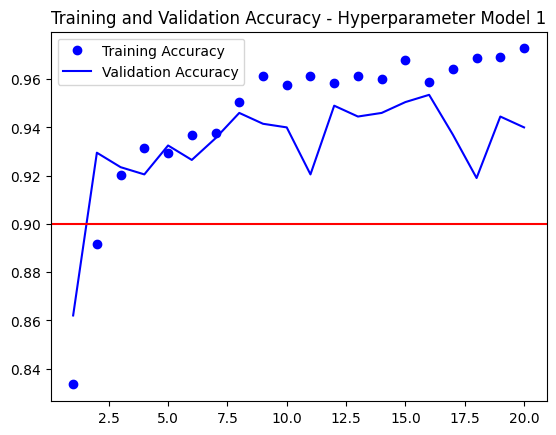

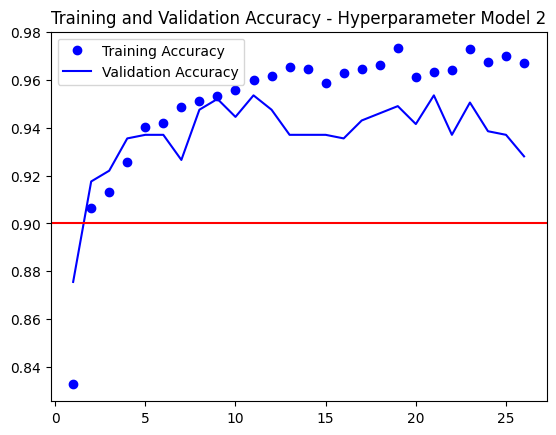

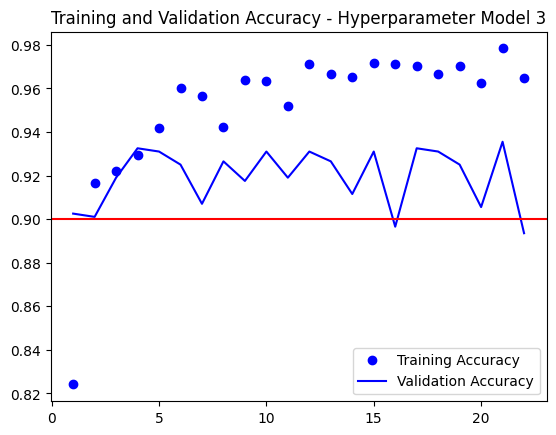

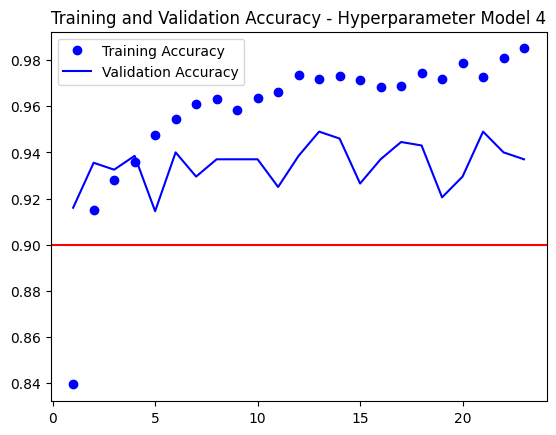

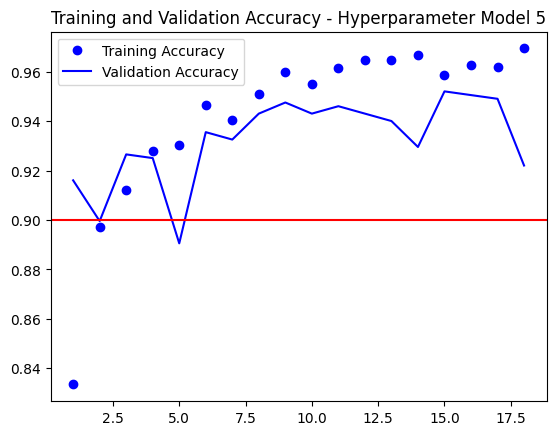

<Figure size 640x480 with 0 Axes>

In [25]:
for i, hist in enumerate(history_ogs):
    plot_hist(hist, 'Hyperparameter Model '+ str(i+1))
    

#### Save the Models

In [27]:
save_path='../3. Model Selection/saved_models/Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/'
for index, hp_mod in enumerate(best_models):
    if not os.path.exists(save_path + str(index + 1) + '/'):
            os.makedirs(save_path + str(index + 1) + '/')
    save_model(hp_mod, save_path + str(index+1) + '/')

Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk


In [ ]:
#below saved files are gitignored

In [28]:
for index, hp_mod in enumerate(best_models):
    if not os.path.exists('./saved_models/my_model' + str(index + 1)):
            os.makedirs('./saved_models/my_model'+ str(index + 1))
    hp_mod.save('./saved_models/my_model'+ str(index+1))